In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split

from pyEDM import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [3]:
pub_dir = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

In [4]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')
swe_anoms = xr.open_dataset('./data/SWE_anoms.nc')

swe_by_eco_files = glob.glob('./data/snow_by_eco/*.nc')

In [5]:
for i in range(15):
    print(i, swe_by_eco_files[i])

0 ./data/snow_by_eco/snow_Klamath_Mountains.nc
1 ./data/snow_by_eco/snow_Middle_Rockies.nc
2 ./data/snow_by_eco/snow_Central_Basin_and_Range.nc
3 ./data/snow_by_eco/snow_Blue_Mountains.nc
4 ./data/snow_by_eco/snow_Canadian_Rockies.nc
5 ./data/snow_by_eco/snow_Eastern_Cascades_Slopes_and_Foothills.nc
6 ./data/snow_by_eco/snow_Wasatch_and_Uinta_Mountains.nc
7 ./data/snow_by_eco/snow_Sierra_Nevada.nc
8 ./data/snow_by_eco/snow_North_Cascades.nc
9 ./data/snow_by_eco/snow_Northern_Basin_and_Range.nc
10 ./data/snow_by_eco/snow_Columbia_Mountains_Northern_Rockies.nc
11 ./data/snow_by_eco/snow_Arizona_New_Mexico_Mountains.nc
12 ./data/snow_by_eco/snow_Southern_Rockies.nc
13 ./data/snow_by_eco/snow_Idaho_Batholith.nc
14 ./data/snow_by_eco/snow_Cascades.nc


In [6]:
goa_sst = sst_anoms.sel(lat=slice(50,40), lon=slice(220,230))

In [76]:
i = 8
swe_anoms_by_eco = xr.open_dataset(swe_by_eco_files[i])

swe_anoms_ts = swe_anoms_by_eco.mean(dim='sites').dropna(dim='time')

# generate predicted SWE from SST
swe = swe_anoms_ts.to_dataframe()
sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()

swe_by_eco_files[i]

'./data/snow_by_eco/snow_North_Cascades.nc'

'./data/snow_by_eco/snow_North_Cascades.nc'

In [77]:
df = swe.join(sst)

df = df.dropna()
df = df.reset_index()
# df = df.drop(['lat', 'lon'], axis=1)

df['time'] = df['time'].map(lambda x: x.isoformat())

In [78]:
df

,time,swe_level2,sst
0,1973-10-01T00:00:00,2.188089,-0.662400
1,1973-11-01T00:00:00,1.487027,-1.167757
2,1973-12-01T00:00:00,1.098851,-1.066915
3,1974-01-01T00:00:00,0.902489,-0.714777
4,1974-02-01T00:00:00,1.253843,-0.576360
...,...,...,...
526,2019-05-01T00:00:00,-0.754103,0.724249
527,2019-06-01T00:00:00,-0.500688,1.322131
528,2019-07-01T00:00:00,-0.119939,2.194706
529,2019-08-01T00:00:00,-0.258992,2.224361


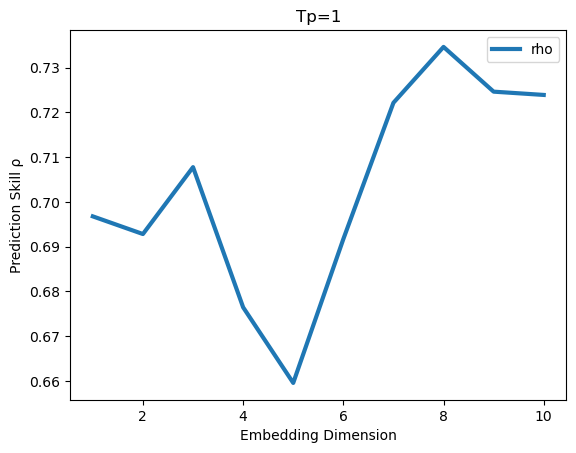

8


In [79]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

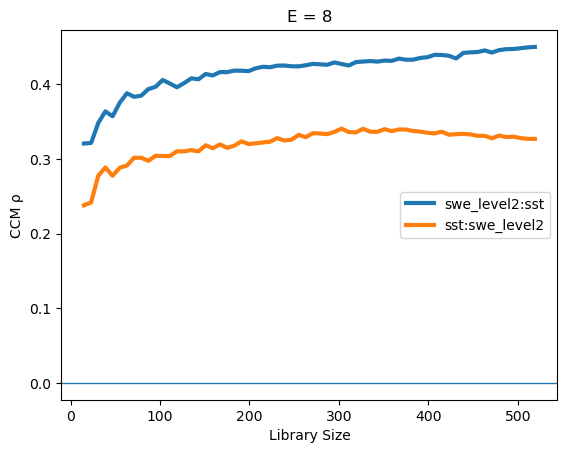

In [80]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

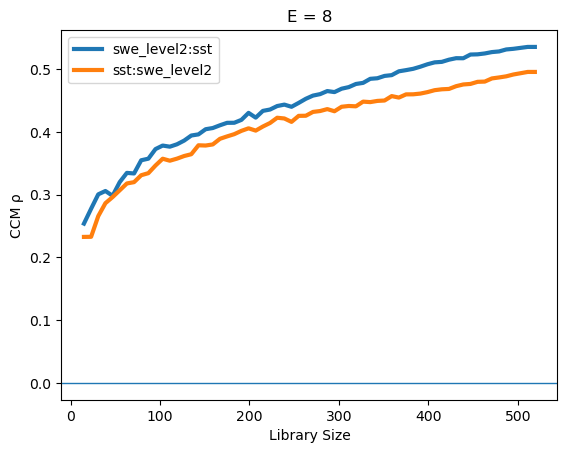

In [81]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

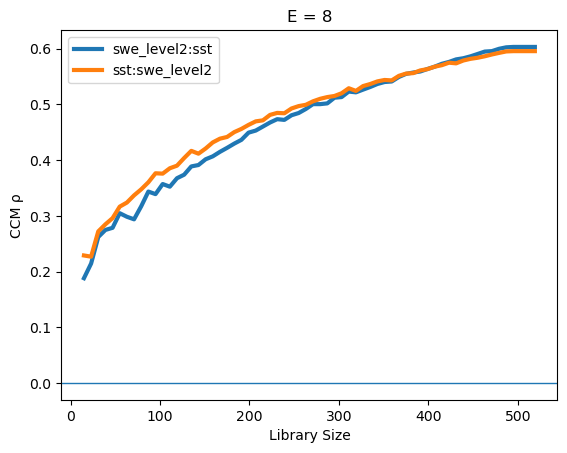

In [82]:
ccm_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

In [15]:
def ccm_projections(ccm_obj):
    ccm_obj.RevMap.FindNeighbors()
    ccm_obj.RevMap.Project()
    ccm_obj.RevMap.FormatProjection()

    ccm_re = ccm_obj.RevMap.Projection
    return(ccm_re)


def lagged_regression(df, lag):
    X = df['sst'][0:-lag].to_numpy()
    y = df['swe_level2'][lag:].to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=42)
    m, b, rho, p, std_err = stats.linregress(x_train, y_train)
    y_pred = m*X - b
    return(y_pred)

In [87]:
ccm_l1_swe_re = ccm_projections(ccm_lag1)
ccm_l3_swe_re = ccm_projections(ccm_lag3)
ccm_l6_swe_re = ccm_projections(ccm_lag6)

In [89]:
ccm_l6_swe_re

,Time,Observations,Predictions,Pred_Variance
0,1978-06-01T00:00:00,-0.570056,0.226266,0.343903
1,1978-10-01T00:00:00,-0.713971,0.069211,0.338039
2,1978-11-01T00:00:00,-0.613949,-0.245393,0.246618
3,1978-12-01T00:00:00,0.108471,-0.047328,0.057462
4,1979-01-01T00:00:00,0.157904,-0.137415,0.084545
...,...,...,...,...
484,2019-05-01T00:00:00,-0.754103,-0.164909,0.267106
485,2019-06-01T00:00:00,-0.500688,-0.112784,0.380470
486,2019-07-01T00:00:00,-0.119939,-0.039450,0.342706
487,2019-08-01T00:00:00,-0.258992,-0.025387,0.349698


In [88]:
reg_l1_swe = lagged_regression(df, 1)
reg_l3_swe = lagged_regression(df, 3)
reg_l6_swe = lagged_regression(df, 6)

In [90]:
ccm_l1_swe_re['dtime'] = ccm_l1_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_l3_swe_re['dtime'] = ccm_l3_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_l6_swe_re['dtime'] = ccm_l6_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [90]:
df['dtime'] = df['time'].map(lambda x: datetime.datetime.fromisoformat(x))

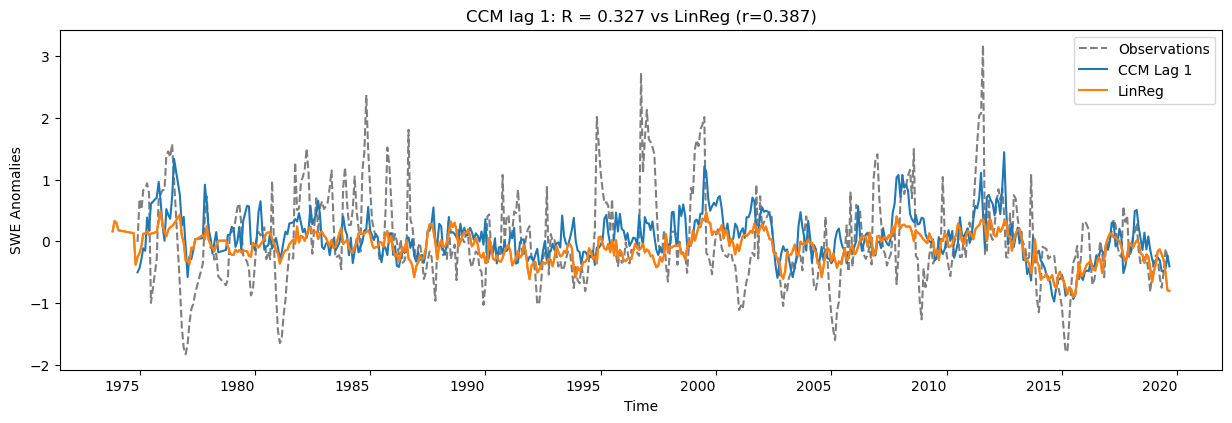

In [89]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', zorder=5)
ccm_l1_swe_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l1_swe_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1', rot=0)
ax.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', label='LinReg')

r1, p1 = stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
r2, p2 = stats.pearsonr(ccm_l1_swe_re['Observations'], ccm_l1_swe_re['Predictions'])

ax.set_title('CCM lag 1: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
# df.plot(ax=ax, x='dtime', y='y_pred_l1')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.legend()
plt.show()

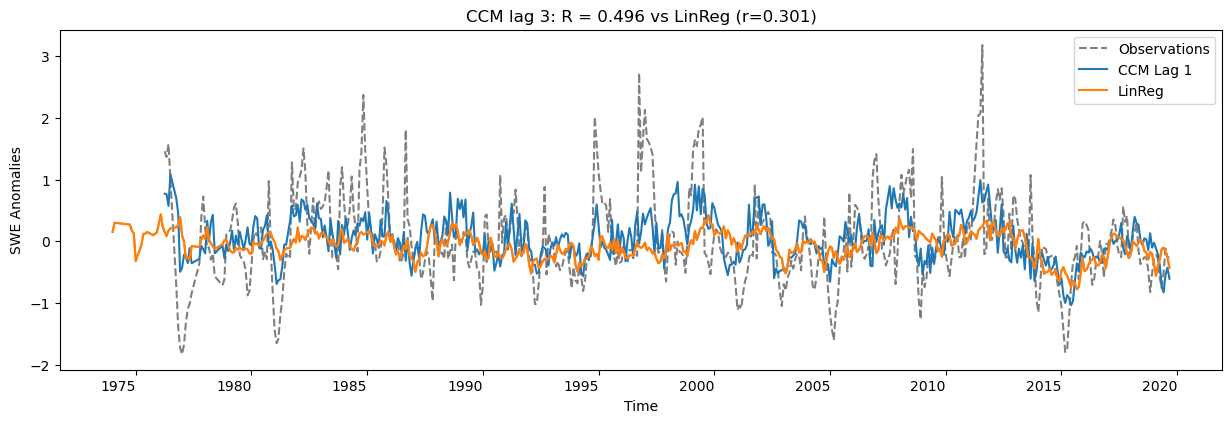

In [90]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', zorder=5)
ccm_l3_swe_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l3_swe_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1', rot=0)
ax.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', label='LinReg')

r1, p1 = stats.pearsonr(reg_l3_swe, df['swe_level2'][3:])
r2, p2 = stats.pearsonr(ccm_l3_swe_re['Observations'], ccm_l3_swe_re['Predictions'])

ax.set_title('CCM lag 3: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
# df.plot(ax=ax, x='dtime', y='y_pred_l1')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.legend()
plt.show()

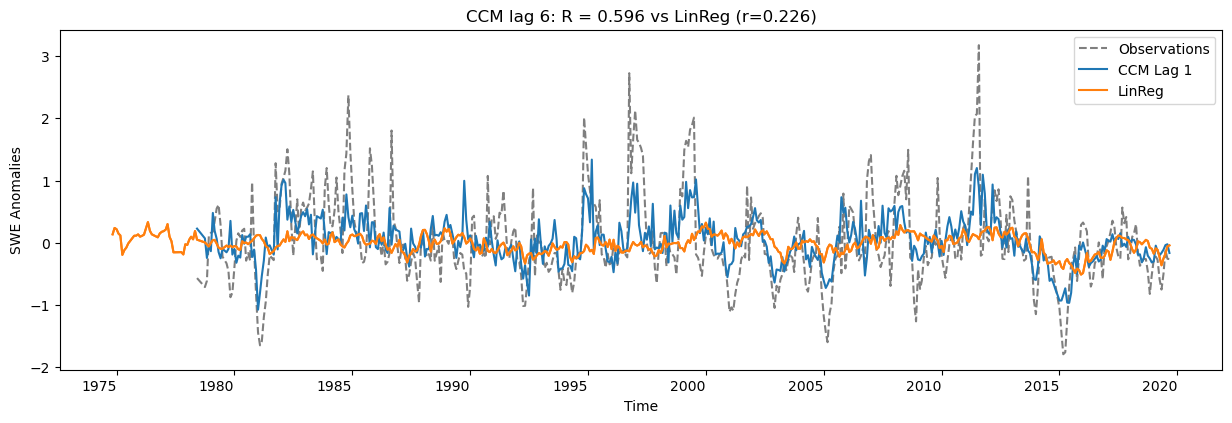

In [91]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', zorder=5)
ccm_l6_swe_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l6_swe_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM Lag 1', rot=0)
ax.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', label='LinReg')

r1, p1 = stats.pearsonr(reg_l6_swe, df['swe_level2'][6:])
r2, p2 = stats.pearsonr(ccm_l6_swe_re['Observations'], ccm_l6_swe_re['Predictions'])

ax.set_title('CCM lag 6: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
# df.plot(ax=ax, x='dtime', y='y_pred_l1')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


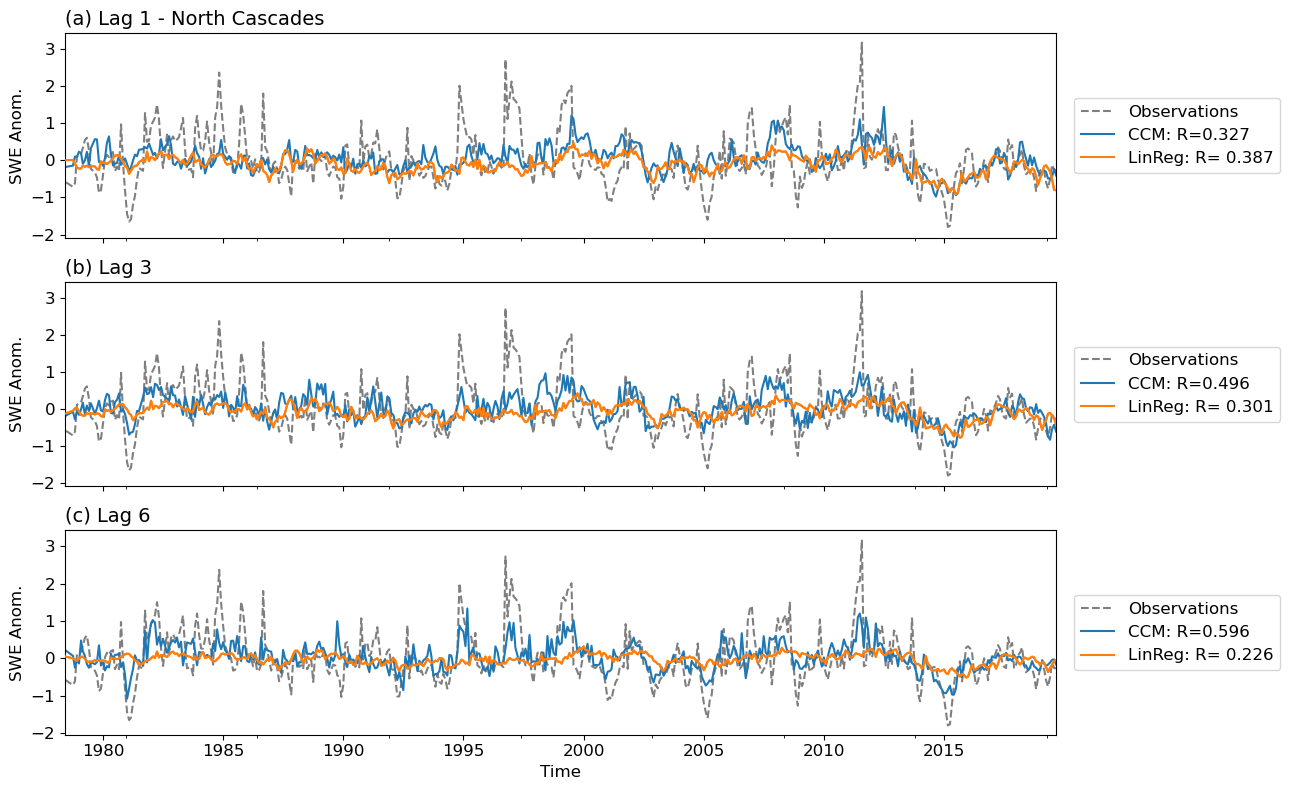

In [91]:
# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
r2, p2 = stats.pearsonr(ccm_l1_swe_re['Observations'], ccm_l1_swe_re['Predictions'])

ax1.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', zorder=5)
ccm_l1_swe_re.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l1_swe_re.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - North Cascades', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax1.set_xlim([ccm_l1_swe_re.dtime[0], ccm_l1_swe_re.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l3_swe, df['swe_level2'][3:])
r2, p2 = stats.pearsonr(ccm_l3_swe_re['Observations'], ccm_l3_swe_re['Predictions'])

ax2.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', zorder=5)
ccm_l3_swe_re.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l3_swe_re.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l6_swe, df['swe_level2'][6:])
r2, p2 = stats.pearsonr(ccm_l6_swe_re['Observations'], ccm_l6_swe_re['Predictions'])

ax3.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', zorder=5)
ccm_l6_swe_re.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l6_swe_re.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(pub_dir+'fig6a_6c.eps',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)
plt.show()

---

In [7]:
i = -1
swe_anoms_by_eco = xr.open_dataset(swe_by_eco_files[i])

swe_anoms_ts = swe_anoms_by_eco.mean(dim='sites').dropna(dim='time')

# generate predicted SWE from SST
swe = swe_anoms_ts.to_dataframe()
sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()

In [8]:
swe_by_eco_files[i]

'./data/snow_by_eco/snow_Cascades.nc'

In [9]:
df = swe.join(sst)

df = df.dropna()
df = df.reset_index()
# df = df.drop(['lat', 'lon'], axis=1)

df['time'] = df['time'].map(lambda x: x.isoformat())

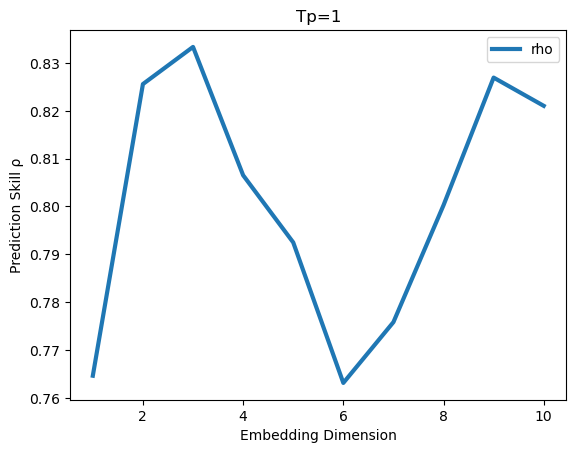

3


In [10]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

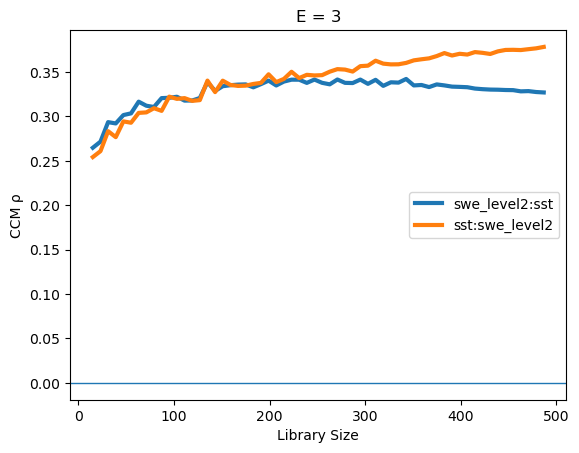

In [11]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

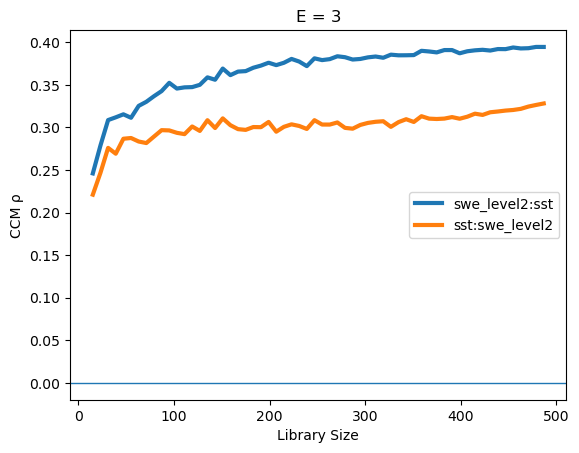

In [12]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

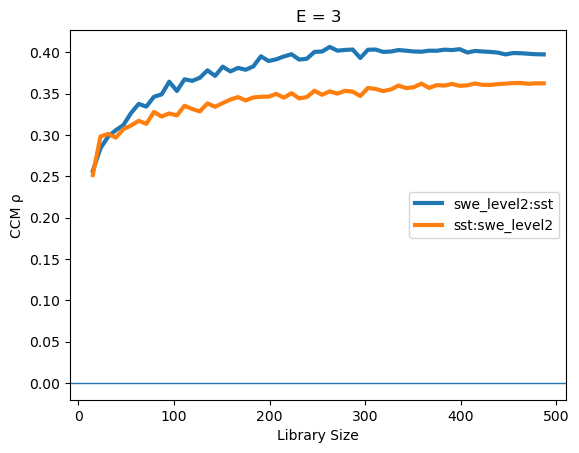

In [13]:
ccm_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

In [16]:
ccm_l1_swe_re = ccm_projections(ccm_lag1)
ccm_l3_swe_re = ccm_projections(ccm_lag3)
ccm_l6_swe_re = ccm_projections(ccm_lag6)

In [17]:
reg_l1_swe = lagged_regression(df, 1)
reg_l3_swe = lagged_regression(df, 3)
reg_l6_swe = lagged_regression(df, 6)

In [18]:
ccm_l1_swe_re['dtime'] = ccm_l1_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_l3_swe_re['dtime'] = ccm_l3_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_l6_swe_re['dtime'] = ccm_l6_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [19]:
df['dtime'] = df['time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [20]:
df

,time,sst,swe_level2,dtime
0,1978-10-01T00:00:00,0.070282,-0.523846,1978-10-01
1,1978-11-01T00:00:00,0.386935,-0.582581,1978-11-01
2,1978-12-01T00:00:00,0.474465,-0.449708,1978-12-01
3,1979-01-01T00:00:00,0.474786,-0.730925,1979-01-01
4,1979-02-01T00:00:00,0.226544,-0.564041,1979-02-01
...,...,...,...,...
487,2019-05-01T00:00:00,0.724249,-0.279344,2019-05-01
488,2019-06-01T00:00:00,1.322131,-0.245479,2019-06-01
489,2019-07-01T00:00:00,2.194706,-0.271610,2019-07-01
490,2019-08-01T00:00:00,2.224361,-0.211882,2019-08-01


In [60]:
hy1 = ccm_l6_swe_re[(ccm_l6_swe_re['dtime']>='2007-10-01')&(ccm_l6_swe_re['dtime']<='2008-09-01')]
hy2 = ccm_l6_swe_re[(ccm_l6_swe_re['dtime']>='1998-10-01')&(ccm_l6_swe_re['dtime']<='1999-09-01')]
hy3 = ccm_l6_swe_re[(ccm_l6_swe_re['dtime']>='1996-10-01')&(ccm_l6_swe_re['dtime']<='1997-09-01')]

In [91]:
ly1 = ccm_l6_swe_re[(ccm_l6_swe_re['dtime']>='2014-10-01')&(ccm_l6_swe_re['dtime']<='2015-09-01')]
ly2 = ccm_l6_swe_re[(ccm_l6_swe_re['dtime']>='2004-10-01')&(ccm_l6_swe_re['dtime']<='2005-09-01')]
ly3 = ccm_l6_swe_re[(ccm_l6_swe_re['dtime']>='2000-10-01')&(ccm_l6_swe_re['dtime']<='2001-09-01')]

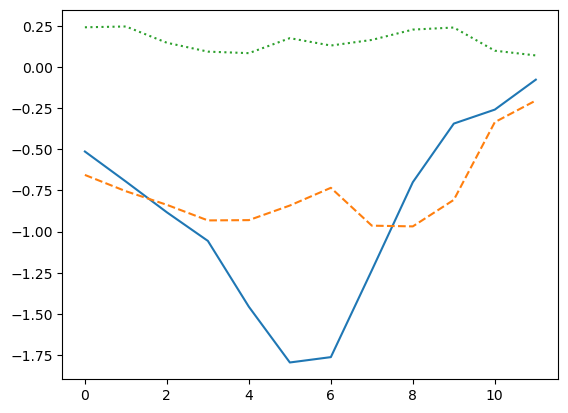

In [94]:
fig, ax = plt.subplots()

xs = np.arange(0,12,1)

ax.plot(xs, ly1.Observations, ls='-')
ax.plot(xs, ly1.Predictions, ls='--')
ax.plot(xs, reg_l6_swe[ly1.index+6], ls=':')

# ax.plot(xs, ly2.Observations, ls='-')
# ax.plot(xs, ly2.Predictions, ls='--')
# ax.plot(xs, reg_l6_swe[ly2.index+6], ls=':')

# ax.plot(xs, ly3.Observations, ls='-')
# ax.plot(xs, ly3.Predictions, ls='--')
# ax.plot(xs, reg_l6_swe[ly3.index+6], ls=':')

In [63]:
hy3

,Time,Observations,Predictions,Pred_Variance,dtime
204,1996-10-01T00:00:00,2.126485,0.244301,0.053681,1996-10-01
205,1996-11-01T00:00:00,1.034368,0.048393,0.099624,1996-11-01
206,1996-12-01T00:00:00,1.854321,0.202982,0.677164,1996-12-01
207,1997-01-01T00:00:00,1.781319,-0.022963,0.108821,1997-01-01
208,1997-02-01T00:00:00,1.324136,0.326873,0.515928,1997-02-01
209,1997-03-01T00:00:00,1.281264,0.441497,0.509168,1997-03-01
210,1997-04-01T00:00:00,1.060821,-0.376656,0.037183,1997-04-01
211,1997-05-01T00:00:00,0.526721,-0.746052,0.290645,1997-05-01
212,1997-06-01T00:00:00,0.052952,-0.358727,0.023978,1997-06-01
213,1997-07-01T00:00:00,0.269149,-0.133742,0.050862,1997-07-01


In [49]:
hy1['dtime'], reg_l6_swe[hy1.index+6]

(336   2007-10-01
 337   2007-11-01
 338   2007-12-01
 339   2008-01-01
 340   2008-02-01
 341   2008-03-01
 342   2008-04-01
 343   2008-05-01
 344   2008-06-01
 345   2008-07-01
 346   2008-08-01
 347   2008-09-01
 Name: dtime, dtype: datetime64[ns],
 array([0.04561912, 0.00882621, 0.06511892, 0.03442976, 0.17878984,
        0.10439862, 0.31362924, 0.21553612, 0.15456863, 0.20033959,
        0.20428309, 0.17793553], dtype=float32))

In [42]:
ccm_l6_swe_re.shape

(480, 5)

In [27]:
ccm_l6_swe_re['Time'].iloc[0]

'1979-10-01T00:00:00'

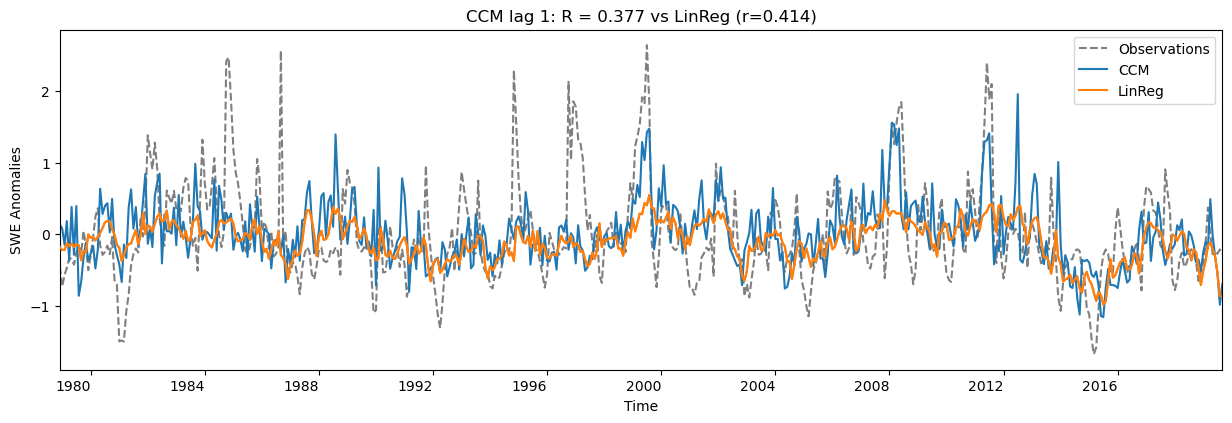

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', zorder=5)
ccm_l1_swe_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l1_swe_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM', rot=0)
ax.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', label='LinReg')

r1, p1 = stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
r2, p2 = stats.pearsonr(ccm_l1_swe_re['Observations'], ccm_l1_swe_re['Predictions'])

ax.set_title('CCM lag 1: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
# df.plot(ax=ax, x='dtime', y='y_pred_l1')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.legend()
ax.set_xlim([ccm_l1_swe_re.dtime[0], ccm_l1_swe_re.dtime.iloc[-1]])
plt.show()

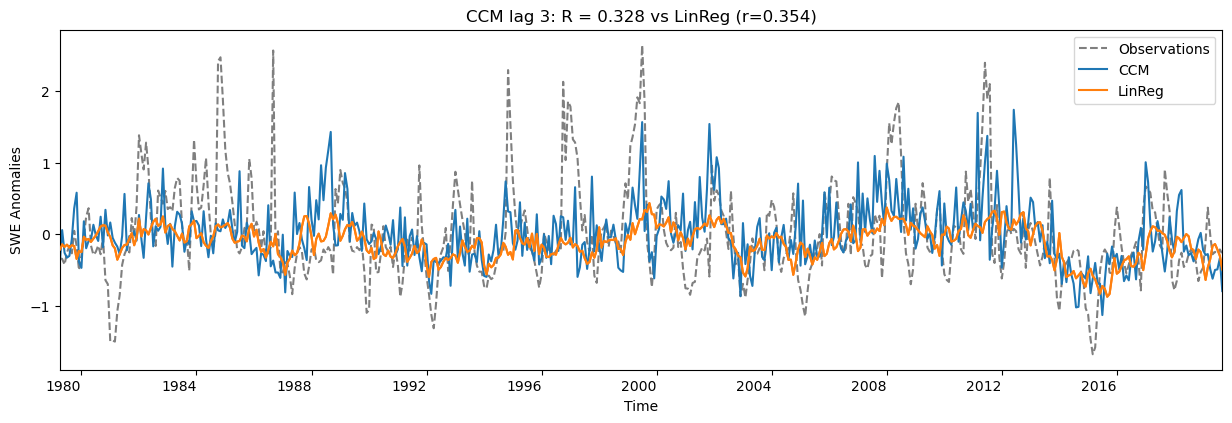

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', zorder=5)
ccm_l3_swe_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l3_swe_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM', rot=0)
ax.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', label='LinReg')

r1, p1 = stats.pearsonr(reg_l3_swe, df['swe_level2'][3:])
r2, p2 = stats.pearsonr(ccm_l3_swe_re['Observations'], ccm_l3_swe_re['Predictions'])

ax.set_title('CCM lag 3: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
# df.plot(ax=ax, x='dtime', y='y_pred_l1')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.legend()
ax.set_xlim([ccm_l3_swe_re.dtime[0], ccm_l3_swe_re.dtime.iloc[-1]])
plt.show()

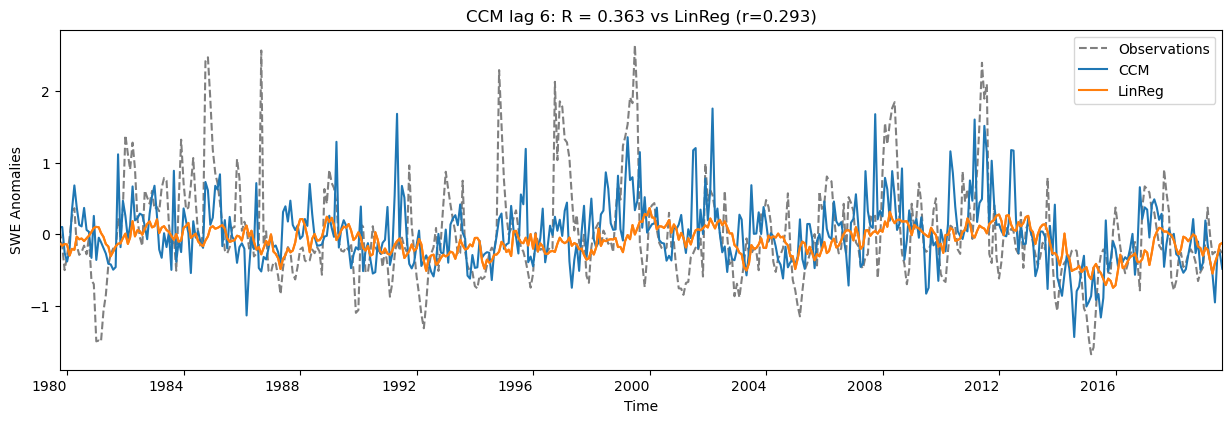

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', zorder=5)
ccm_l6_swe_re.plot(ax=ax, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l6_swe_re.plot(ax=ax, x='dtime', y='Predictions', label='CCM', rot=0)
ax.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', label='LinReg')

r1, p1 = stats.pearsonr(reg_l6_swe, df['swe_level2'][6:])
r2, p2 = stats.pearsonr(ccm_l6_swe_re['Observations'], ccm_l6_swe_re['Predictions'])

ax.set_title('CCM lag 6: R = {:.3f} vs LinReg (r={:.3f})'.format(r2, r1))
# df.plot(ax=ax, x='dtime', y='swe_level2')
# df.plot(ax=ax, x='dtime', y='y_pred_l1')
ax.set_xlabel('Time')
ax.set_ylabel('SWE Anomalies')
ax.legend()
ax.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


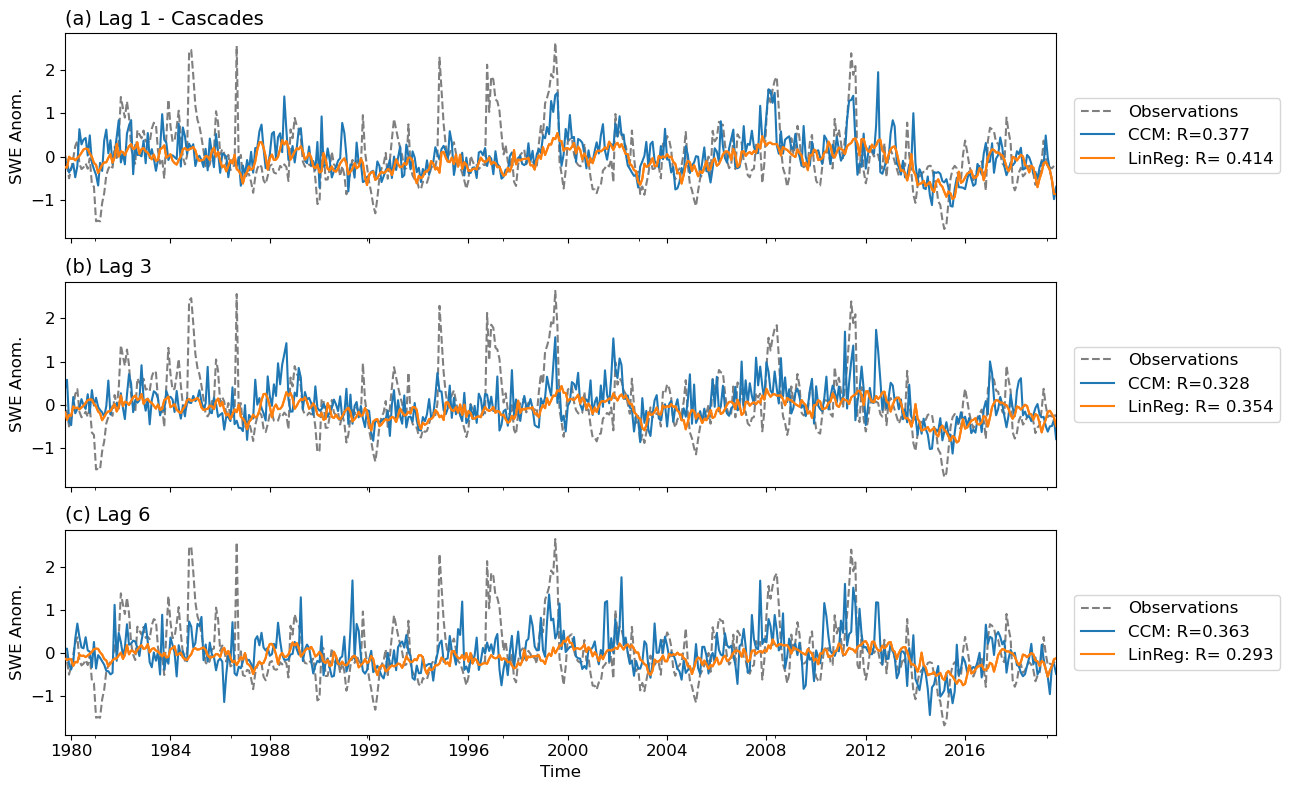

In [76]:
# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
r2, p2 = stats.pearsonr(ccm_l1_swe_re['Observations'], ccm_l1_swe_re['Predictions'])

ax1.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', zorder=5)
ccm_l1_swe_re.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l1_swe_re.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - Cascades', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax1.set_xlim([ccm_l1_swe_re.dtime[0], ccm_l1_swe_re.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l3_swe, df['swe_level2'][3:])
r2, p2 = stats.pearsonr(ccm_l3_swe_re['Observations'], ccm_l3_swe_re['Predictions'])

ax2.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', zorder=5)
ccm_l3_swe_re.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l3_swe_re.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l6_swe, df['swe_level2'][6:])
r2, p2 = stats.pearsonr(ccm_l6_swe_re['Observations'], ccm_l6_swe_re['Predictions'])

ax3.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', zorder=5)
ccm_l6_swe_re.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l6_swe_re.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(pub_dir+'fig5a_5c.eps',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)
plt.show()

---

In [92]:
i = 10
swe_anoms_by_eco = xr.open_dataset(swe_by_eco_files[i])

swe_anoms_ts = swe_anoms_by_eco.mean(dim='sites').dropna(dim='time')

# generate predicted SWE from SST
swe = swe_anoms_ts.to_dataframe()
sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()

swe_by_eco_files[i]

'./data/snow_by_eco/snow_Columbia_Mountains_Northern_Rockies.nc'

In [93]:
df = swe.join(sst)

df = df.dropna()
df = df.reset_index()
# df = df.drop(['lat', 'lon'], axis=1)

df['time'] = df['time'].map(lambda x: x.isoformat())

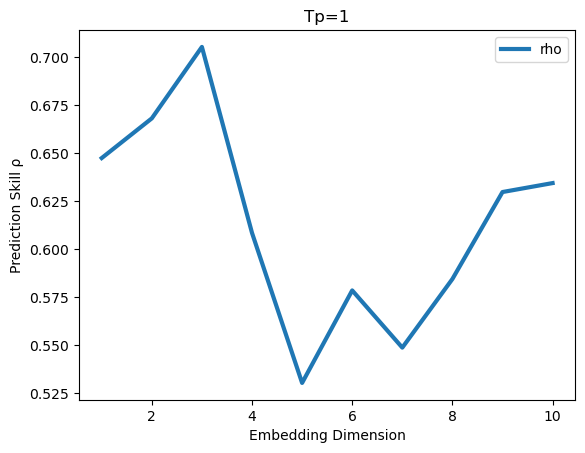

3


In [94]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst',
    showPlot=True
)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

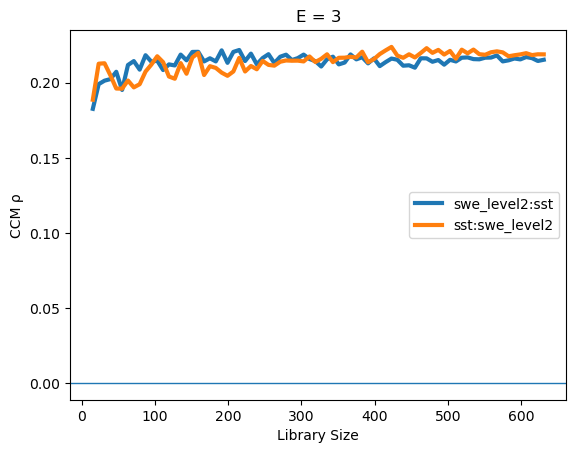

In [95]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

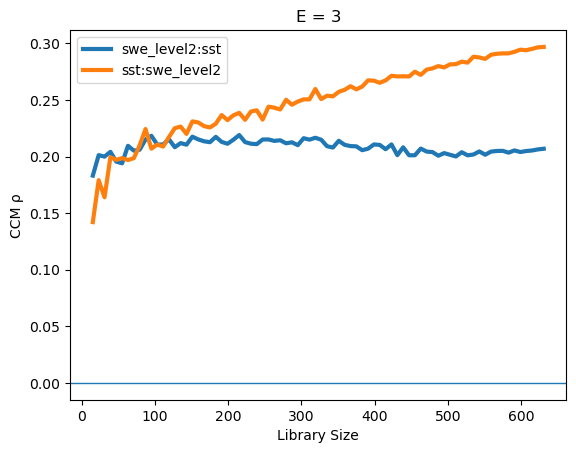

In [96]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

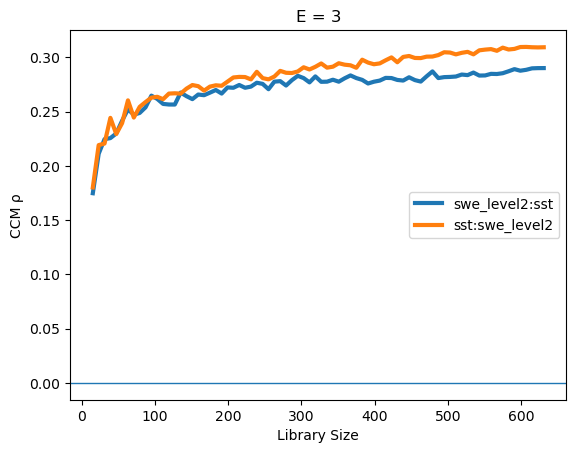

In [97]:
ccm_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100, 
               showPlot=True, returnObject=True)

In [98]:
ccm_l1_swe_re = ccm_projections(ccm_lag1)
ccm_l3_swe_re = ccm_projections(ccm_lag3)
ccm_l6_swe_re = ccm_projections(ccm_lag6)

In [99]:
reg_l1_swe = lagged_regression(df, 1)
reg_l3_swe = lagged_regression(df, 3)
reg_l6_swe = lagged_regression(df, 6)

In [100]:
ccm_l1_swe_re['dtime'] = ccm_l1_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_l3_swe_re['dtime'] = ccm_l3_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
ccm_l6_swe_re['dtime'] = ccm_l6_swe_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))

In [101]:
df['dtime'] = df['time'].map(lambda x: datetime.datetime.fromisoformat(x))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


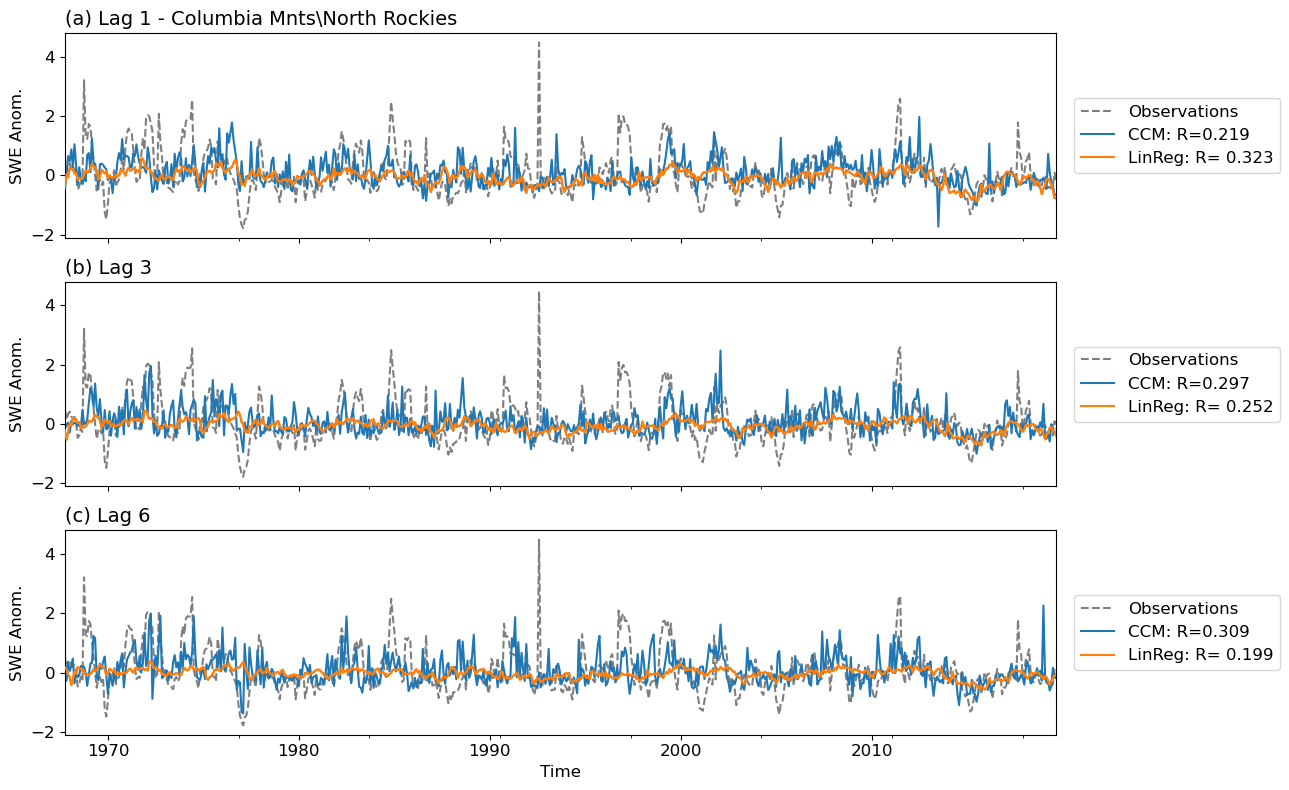

In [103]:
# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
r2, p2 = stats.pearsonr(ccm_l1_swe_re['Observations'], ccm_l1_swe_re['Predictions'])

ax1.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', zorder=5)
ccm_l1_swe_re.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l1_swe_re.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df['dtime'][1:], reg_l1_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - Columbia Mnts\\North Rockies', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax1.set_xlim([ccm_l1_swe_re.dtime[0], ccm_l1_swe_re.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l3_swe, df['swe_level2'][3:])
r2, p2 = stats.pearsonr(ccm_l3_swe_re['Observations'], ccm_l3_swe_re['Predictions'])

ax2.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', zorder=5)
ccm_l3_swe_re.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l3_swe_re.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df['dtime'][3:], reg_l3_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(reg_l6_swe, df['swe_level2'][6:])
r2, p2 = stats.pearsonr(ccm_l6_swe_re['Observations'], ccm_l6_swe_re['Predictions'])

ax3.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', zorder=5)
ccm_l6_swe_re.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
ccm_l6_swe_re.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df['dtime'][6:], reg_l6_swe, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([ccm_l6_swe_re.dtime[0], ccm_l6_swe_re.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

plt.savefig(pub_dir+'fig7a_7c.eps',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)
plt.show()

---

In [28]:
df_pre1999 = df[df['dtime'].dt.year<1999]
ccm_l1_pre1999 = ccm_l1_swe_re[ccm_l1_swe_re['dtime'].dt.year<1999]
# stats.pearsonr(reg_l1_swe, df['swe_level2'][1:])
stats.pearsonr(ccm_l1_pre1999['Observations'], ccm_l1_pre1999['Predictions'])


PearsonRResult(statistic=0.15708147086358942, pvalue=0.014644429130582717)

In [29]:
df_post1999 = df[df['dtime'].dt.year>1999]
ccm_l1_post1999 = ccm_l1_swe_re[ccm_l1_swe_re['dtime'].dt.year>1999]
stats.pearsonr(ccm_l1_post1999['Observations'], ccm_l1_post1999['Predictions'])

PearsonRResult(statistic=0.4721766138679096, pvalue=1.456713527427994e-14)

In [30]:
ccm_l6_swe_re[ccm_l6_swe_re['Observations']<-0.8]

,Time,Observations,Predictions,Pred_Variance,dtime
15,1981-01-01T00:00:00,-1.493853,-0.357801,0.379939,1981-01-01
16,1981-02-01T00:00:00,-1.481754,-0.047706,0.027878,1981-02-01
17,1981-03-01T00:00:00,-1.496783,-0.109815,0.220579,1981-03-01
18,1981-04-01T00:00:00,-1.070405,-0.189892,0.151768,1981-04-01
19,1981-05-01T00:00:00,-0.844658,-0.269958,0.198885,1981-05-01
91,1987-05-01T00:00:00,-0.835549,-0.426290,0.075182,1987-05-01
122,1989-12-01T00:00:00,-1.095837,-0.181202,0.316806,1989-12-01
123,1990-01-01T00:00:00,-1.057435,-0.214279,0.296971,1990-01-01
136,1991-02-01T00:00:00,-0.870773,-0.427925,0.140437,1991-02-01
148,1992-02-01T00:00:00,-0.838894,0.051336,0.321662,1992-02-01


Text(0.0, 1.0, 'North Cascades SST Composites')

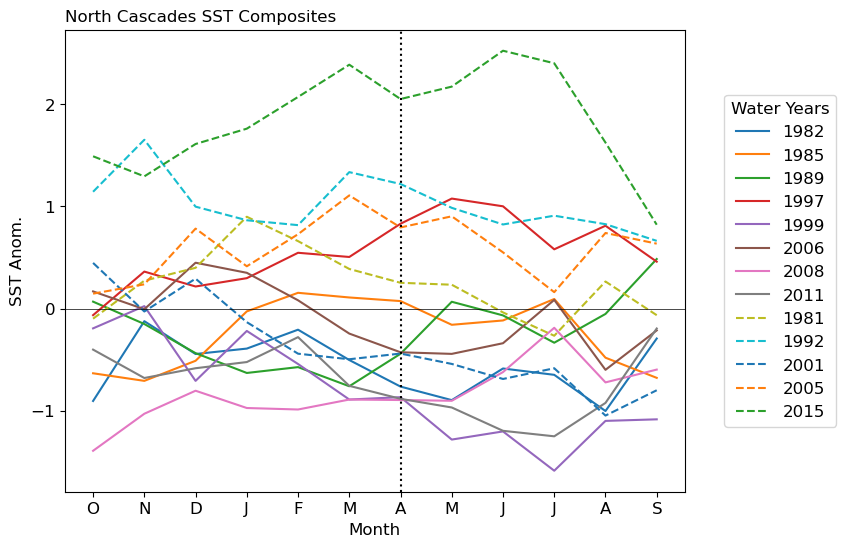

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
# goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1973-10-01','1974-09-01')).to_pandas().reset_index().plot(y=0,
#                                                                                                                ax=ax,
#                                                                                                                label='1974')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1981-10-01','1982-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1982')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1984-10-01','1985-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1985')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1988-10-01','1989-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1989')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1997')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1999')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2005-10-01','2006-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='2006')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2007-10-01','2008-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='2008')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2010-10-01','2011-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='2011')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='1981')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1991-10-01','1992-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='1992')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2001')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2005')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2015')
ax.axhline(0, color='k', lw=0.5)
plt.rcParams['legend.title_fontsize'] = 12
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years', fontsize=12)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('SST Anom.', fontsize=12)
ax.axvline(6, color='k', ls=':')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('North Cascades SST Composites', loc='left')
# plt.savefig(pub_dir+'north_cascades_composite.png',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

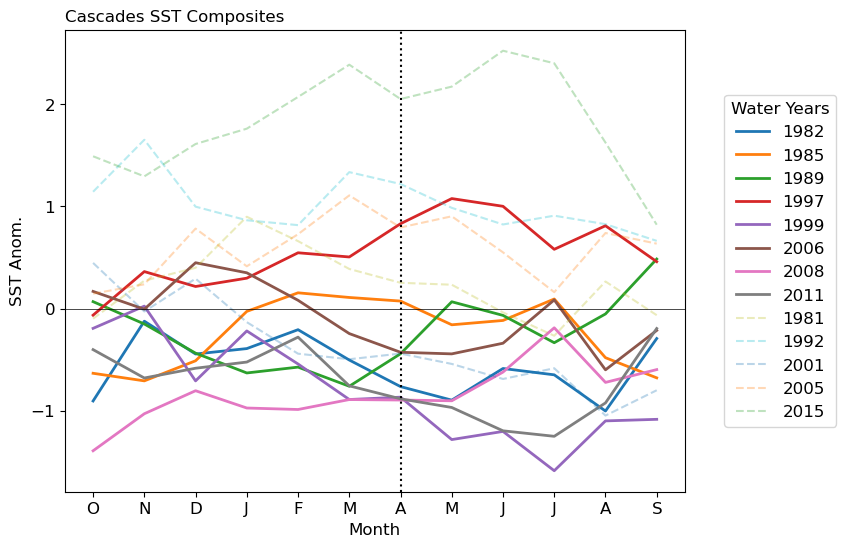

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1981-10-01','1982-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1982', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1984-10-01','1985-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1985', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1988-10-01','1989-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1989', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1997', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1999', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2005-10-01','2006-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='2006', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2007-10-01','2008-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='2008', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2010-10-01','2011-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='2011', lw=2)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='1981', alpha=0.3)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1991-10-01','1992-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='1992', alpha=0.3)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2001', alpha=0.3)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2005', alpha=0.3)
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2015', alpha=0.3)
ax.axhline(0, color='k', lw=0.5)
plt.rcParams['legend.title_fontsize'] = 12
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years', fontsize=12)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('SST Anom.', fontsize=12)
ax.axvline(6, color='k', ls=':')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Cascades SST Composites', loc='left')
# plt.savefig(pub_dir+'cascades_composite.png',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)
plt.show()


In [133]:
nc_wy1982_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1981-10-01','1982-09-01'))
nc_wy1985_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1984-10-01','1985-09-01'))
nc_wy1989_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1988-10-01','1989-09-01'))
nc_wy1997_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01'))
nc_wy1999_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01'))
nc_wy2006_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2005-10-01','2006-09-01'))
nc_wy2008_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2007-10-01','2008-09-01'))
nc_wy2011_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2010-10-01','2011-09-01'))

h_mean_c = np.mean([nc_wy1982_h, nc_wy1985_h, nc_wy1989_h,
                    nc_wy1997_h, nc_wy1999_h, nc_wy2006_h,
                    nc_wy2008_h, nc_wy2011_h], axis=0)
h_std_c = np.std([nc_wy1982_h, nc_wy1985_h, nc_wy1989_h,
                  nc_wy1997_h, nc_wy1999_h, nc_wy2006_h,
                  nc_wy2008_h, nc_wy2011_h], axis=0)

nc_wy1981_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01'))
nc_wy1992_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1991-10-01','1992-09-01'))
nc_wy2001_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01'))
nc_wy2005_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01'))
nc_wy2015_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01'))

l_mean_c = np.mean([nc_wy1981_l, nc_wy1992_l, nc_wy2001_l,
                    nc_wy2005_l, nc_wy2015_l], axis=0)
l_std_c = np.std([nc_wy1981_l, nc_wy1992_l, nc_wy2001_l,
                  nc_wy2005_l, nc_wy2015_l], axis=0)

In [134]:
nc_wy1974_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1973-10-01','1974-09-01'))
nc_wy1975_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1974-10-01','1975-09-01'))
nc_wy1976_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1975-10-01','1976-09-01'))
nc_wy1978_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1977-10-01','1978-09-01'))
nc_wy1999_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01'))

h_mean_nc = np.mean([nc_wy1974_h, nc_wy1975_h, nc_wy1976_h,
                     nc_wy1978_h, nc_wy1999_h], axis=0)
h_std_nc = np.std([nc_wy1974_h, nc_wy1975_h, nc_wy1976_h,
                   nc_wy1978_h, nc_wy1999_h], axis=0)

nc_wy1981_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01'))
nc_wy2001_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01'))
nc_wy2005_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01'))
nc_wy2015_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01'))
l_mean_nc = np.mean([nc_wy1981_l, nc_wy2001_l,
                    nc_wy2005_l, nc_wy2015_l], axis=0)
l_std_nc = np.std([nc_wy1981_l, nc_wy2001_l,
                  nc_wy2005_l, nc_wy2015_l], axis=0)

In [137]:
nc_wy1967_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1966-10-01','1967-09-01'))
nc_wy1968_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1967-10-01','1968-09-01'))
nc_wy1971_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1970-10-01','1971-09-01'))
nc_wy1972_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1971-10-01','1972-09-01'))
nc_wy1974_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1973-10-01','1974-09-01'))
nc_wy1997_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01'))
nc_wy1999_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01'))
h_mean_cmnr = np.mean([nc_wy1967_h, nc_wy1968_h, nc_wy1971_h,
                     nc_wy1972_h, nc_wy1974_h, nc_wy1997_h,
                     nc_wy1999_h], axis=0)
h_std_cmnr = np.std([nc_wy1967_h, nc_wy1968_h, nc_wy1971_h,
                     nc_wy1972_h, nc_wy1974_h, nc_wy1997_h,
                     nc_wy1999_h], axis=0)

nc_wy1977_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1976-10-01','1977-09-01'))
nc_wy2001_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01'))
nc_wy2005_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01'))
nc_wy2015_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01'))
l_mean_cmnr = np.mean([nc_wy1977_l, nc_wy2001_l,
                    nc_wy2005_l, nc_wy2015_l], axis=0)
l_std_cmnr = np.std([nc_wy1977_l, nc_wy2001_l,
                  nc_wy2005_l, nc_wy2015_l], axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


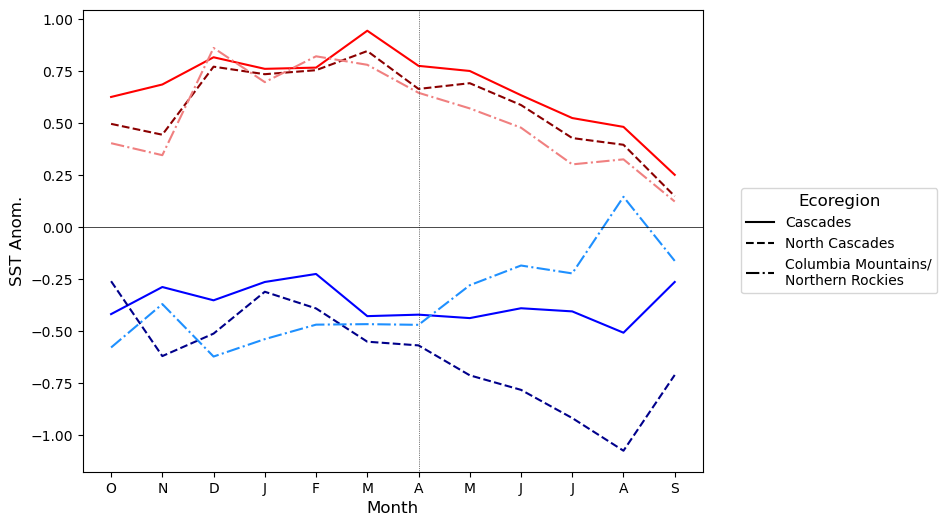

In [173]:
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls='-', color='k'),
                Line2D([0], [0], ls='--',color='k'),
                Line2D([0], [0], ls='-.', color='k')]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(0,12), h_mean_c, color='blue', label='Cascades, high snow')
ax.plot(np.arange(0,12), l_mean_c, color='red', label='Cascades, low snow')

ax.plot(np.arange(0,12), h_mean_nc, color='darkblue', ls='--', label='North Cascades, high snow')
ax.plot(np.arange(0,12), l_mean_nc, color='darkred', ls='--', label='North Cascades, low snow')

ax.plot(np.arange(0,12), h_mean_cmnr, color='dodgerblue', ls='-.', label='Columbia Mountains/\nNorthern Rockies, high snow')
ax.plot(np.arange(0,12), l_mean_cmnr, color='lightcoral', ls='-.', label='Columbia Mountains/\nNorthern Rockies, low snow')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
ax.axvline(6, color='k', ls=':', lw=0.5)
ax.axhline(0, color='k', lw=0.5)
ax.legend(custom_lines, ['Cascades', 'North Cascades', 'Columbia Mountains/\nNorthern Rockies'],
          bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, title='Ecoregion')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('SST Anom.', fontsize=12)
# plt.savefig(pub_dir+'fig8.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=100)

In [179]:
l_std_c, l_std_nc.mean(), l_std_cmnr.mean()

(array([0.600146  , 0.6608062 , 0.47163352, 0.6240752 , 0.7967369 ,
        0.9633618 , 0.8451771 , 0.8981851 , 1.0779061 , 1.062943  ,
        0.8800873 , 0.60715425], dtype=float32),
 0.84563756,
 0.880719)

In [180]:
h_std_c, h_std_nc.mean(), h_std_cmnr.mean()

(array([0.49803534, 0.43624216, 0.41654116, 0.42859948, 0.45243013,
        0.47979707, 0.5660318 , 0.7108019 , 0.6629249 , 0.6780574 ,
        0.58797926, 0.5055489 ], dtype=float32),
 0.50214815,
 0.6333069)

In [51]:
ccm_l1_swe_re[ccm_l1_swe_re['Predictions']>1]

,Time,Observations,Predictions,Pred_Variance,dtime
116,1988-08-01T00:00:00,-0.178968,1.393574,0.290505,1988-08-01
245,1999-05-01T00:00:00,1.910340,1.286661,1.280977,1999-05-01
246,1999-06-01T00:00:00,1.828672,1.034169,1.185464,1999-06-01
247,1999-07-01T00:00:00,2.637399,1.424884,0.698065,1999-07-01
248,1999-08-01T00:00:00,1.841478,1.474727,0.870192,1999-08-01
346,2007-10-01T00:00:00,0.258631,1.176321,1.173223,2007-10-01
350,2008-02-01T00:00:00,1.552380,1.556574,0.027174,2008-02-01
351,2008-03-01T00:00:00,1.256791,1.528844,0.073591,2008-03-01
352,2008-04-01T00:00:00,1.555292,1.244279,0.167333,2008-04-01
353,2008-05-01T00:00:00,1.760855,1.475875,0.016489,2008-05-01


In [24]:
sst_ref = df[['time', 'sst']]
sst_ref['dtime'] = sst_ref['time'].map(lambda x: datetime.datetime.fromisoformat(x))

sst_ref.drop(['time'], axis=1, inplace=True)
sst_ref.set_index('dtime', inplace=True)

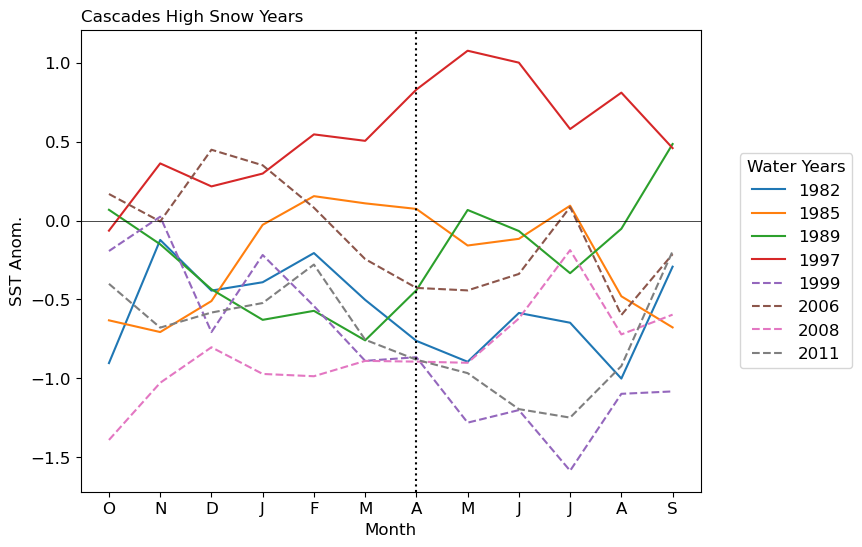

In [36]:
fig, ax = plt.subplots(figsize=(8,6))
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1981-10-01','1982-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1982')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1984-10-01','1985-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1985')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1988-10-01','1989-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1989')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1997')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='1999')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2005-10-01','2006-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2006')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2007-10-01','2008-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2008')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2010-10-01','2011-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2011')
ax.axhline(0, color='k', lw=0.5)
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years', fontsize=12)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('SST Anom.', fontsize=12)
ax.axvline(6, color='k', ls=':')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Cascades High Snow Years', fontsize=12, loc='left')
# plt.savefig(pub_dir+'post_pre_1999_high.png',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)
plt.show()

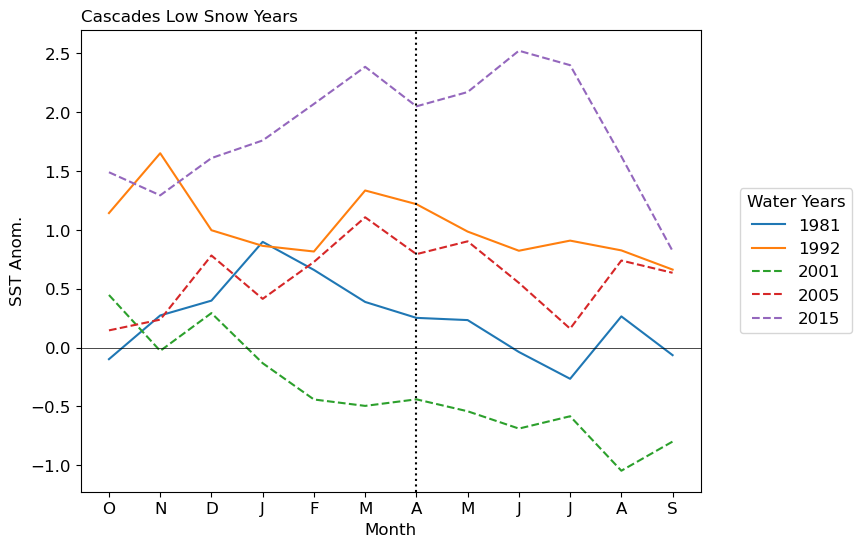

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1981')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1991-10-01','1992-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,
                                                                                                               label='1992')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2001')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2005')
goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01')).to_pandas().reset_index().plot(y=0,
                                                                                                               ax=ax,ls='--',
                                                                                                               label='2015')
ax.axhline(0, color='k', lw=0.5)
ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', title='Water Years', fontsize=12)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
ax.axvline(6, color='k', ls=':')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('SST Anom.', fontsize=12)
ax.set_title('Cascades Low Snow Years', fontsize=12, loc='left')
ax.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig(pub_dir+'post_pre_1999_low.png',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)
plt.show()

In [1]:
ccm_lag1

NameError: name 'ccm_lag1' is not defined